# Training your first MIL model

In the following, we explain how to train a simple Multiple Instance Learning (MIL) model using the <tt>torchmil</tt> library.

In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## The dataset

!!! example "MIL binary classification"
    In this case, the bags have the form $\mathbf{X} = \left[ \mathbf{x}_1, \ldots, \mathbf{x}_N \right]^\top \in \mathbb{R}^{N \times D}$, where each $\mathbf{x}_n \in \mathbb{R}^D$ is an instance. 
    The labels of the instances are $\mathbf{y} = \left[ y_1, \ldots, y_N \right]^\top \in \{0, 1\}^N$, but we do not have access to them at training time (they may be accessible at test time). The label of the bag is $Y \in \{0, 1\}$, and the relation between the instance labels and the bag label is as follows:

    $$ Y = \max \left\{ y_1, \ldots, y_N \right\} $$

    This example is the most common in MIL, but there are many other possibilities. 

We will create a synthetic MIL dataset from the MNIST dataset using the `ToyDataset` from the [<tt>torchmil.datasets</tt>](../api/datasets/index.md) module. The `ToyDataset` generates an MIL dataset from a labeled dataset by specifying the desired bag size and the objective labels, which determine positive instances. Subsequently, `ToyDataset` constructs bags of the specified size and labels them based on these objective labels. For further details, refer to [here](../api/datasets/toy_dataset.md) for more details.

In this example, we are going to set `obj_labels=[2, 5, 8]`. This means that a bag is positive if it contains at least one instance with label 5 or 8.

In [2]:
from torchvision import datasets, transforms
from torchmil.datasets import ToyDataset

# Load MNIST dataset
mnist = datasets.MNIST(
    "/tmp/", train=True, download=True, transform=transforms.ToTensor()
)

# Extract features and labels
data = mnist.data.view(-1, 28 * 28) / 255.0
labels = mnist.targets

# Define positive labels
obj_labels = [0, 1]

# Define bag size
bag_size = (7, 12)  # Randomly sample between 8 and 12 instances per bag

# Create MIL dataset
train_dataset = ToyDataset(
    data, labels, num_bags=10000, obj_labels=obj_labels, bag_size=bag_size, seed=0
)
test_dataset = ToyDataset(
    data, labels, num_bags=2000, obj_labels=obj_labels, bag_size=bag_size, seed=2
)

# Print one bag
print(train_dataset[0])

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([11, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        y_inst: Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)


In <tt>torchmil</tt>, each bag is a `TensorDict`. The different keys correspond to different elements of the bag. In this case, each bag has a feature matrix `X`, the bag label `Y`, and the instance labels `y_inst`. Recall that the instance labels cannot be used during training, they are available only for evaluation purposes.

## Mini-batching of bags

Tipically, the bags in a MIL dataset have different size. This can be a problem when creating mini-batches. To solve this, we use the function `collate_fn` from the [<tt><b>torchmil.data</b></tt>](../api/data/index.md) module. This function creates a mini-batch of bags by padding the bags with zeros to the size of the largest bag in the batch. The function also returns a mask tensor that indicates which instances are real and which are padding.

!!! question "Why not use [`torch.nested`](https://pytorch.org/docs/stable/nested.html)?"
    `torch.nested` offer a more flexible method for handling bags of varying sizes. However, since the PyTorch API for nested tensors is still in the prototype stage, <tt><b>torchmil</b></tt> currently relies on the padding approach.

Let's create the dataloaders and visualize some bags from a mini-batch.

In [3]:
from torchmil.data import collate_fn

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([32, 11, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([32]), device=cpu, dtype=torch.int64, is_shared=False),
        mask: Tensor(shape=torch.Size([32, 11]), device=cpu, dtype=torch.uint8, is_shared=False),
        y_inst: Tensor(shape=torch.Size([32, 11]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)


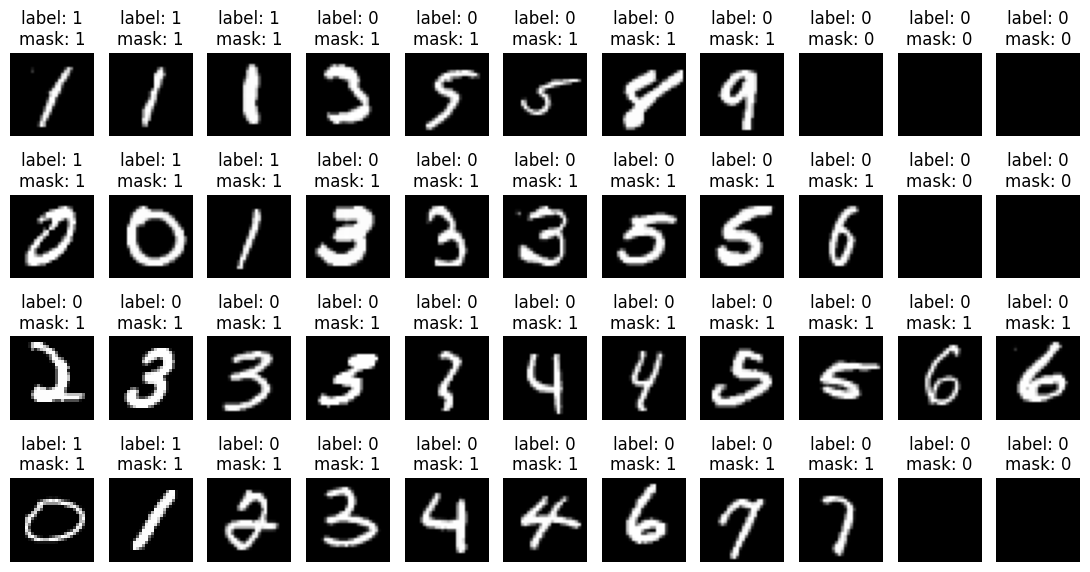

In [4]:
import matplotlib.pyplot as plt


def plot_batch(batch, max_bags=5):
    batch_size = min(len(batch["X"]), max_bags)
    bag_size = len(batch["X"][0])
    fig, axes = plt.subplots(batch_size, bag_size, figsize=(bag_size, 1.5 * batch_size))
    for i in range(batch_size):
        for j in range(bag_size):
            ax = axes[i, j]
            ax.imshow(batch["X"][i][j].view(28, 28), cmap="gray")
            title_str = f"label: {batch['y_inst'][i][j].item()}\nmask: {batch['mask'][i][j].item()}"
            ax.set_title(title_str)
            ax.axis("off")
    plt.tight_layout()
    plt.show()


batch = next(iter(train_dataloader))
print(batch)
plot_batch(batch, max_bags=4)

Each batch is again a `TensorDict` with an additional key `mask` that indicates which instances are real and which are padding. As we can see, the bags are padded to the maximum size of the bags in the batch with zeros. The mask tensor indicates which elements are real instances and which are padding. The function `collate_fn` also pads other tensors, such as the adjacency matrix or the instance coordinates. 

## The model

In this example, we are going to use the [ABMIL](../api/models/abmil.md) model. 
Although it is readily available in the [<tt><b>torchmil.models</b></tt>](../api/models/index.md) module, we are going to implement a simple variation from scratch to show how to create a custom MIL model.

In [5]:
from torchmil.nn import masked_softmax


class ABMIL(torch.nn.Module):
    def __init__(self, emb_dim, att_dim):
        super().__init__()

        # Feature extractor
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, emb_dim),
        )

        self.fc1 = torch.nn.Linear(emb_dim, att_dim)
        self.fc2 = torch.nn.Linear(att_dim, 1)

        self.classifier = torch.nn.Linear(emb_dim, 1)

    def forward(self, X, mask, return_att=False):
        X = self.mlp(X)  # (batch_size, bag_size, emb_dim)
        H = torch.tanh(self.fc1(X))  # (batch_size, bag_size, att_dim)
        att = torch.sigmoid(self.fc2(H))  # (batch_size, bag_size, 1)
        att_s = masked_softmax(att, mask)  # (batch_size, bag_size, 1)
        # att_s = torch.nn.functional.softmax(att, dim=1)
        X = torch.bmm(att_s.transpose(1, 2), X).squeeze(1)  # (batch_size, emb_dim)
        y = self.classifier(X).squeeze(1)  # (batch_size,)
        if return_att:
            return y, att_s
        else:
            return y


model = ABMIL(emb_dim=256, att_dim=128)
print(model)

ABMIL(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
  )
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (classifier): Linear(in_features=256, out_features=1, bias=True)
)


## Training the model

Great! Now, let's train the model. We are going to use the `torch.optim.Adam` optimizer and the `torch.nn.BCEWithLogitsLoss` loss function. We will train the model for 20 epochs.

Thanks to the <tt>torchmil</tt> library, training a MIL model is as simple as training a standard PyTorch model. The training loop is straightforward, similar to the standard PyTorch training loop. We iterate over the training dataloader, compute the loss, and update the model parameters. We also track the loss and accuracy.

In [6]:
model = ABMIL(emb_dim=256, att_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss(reduction="mean")


def train(dataloader, epoch):
    model.train()

    sum_loss = 0.0
    sum_correct = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        out = model(batch["X"], batch["mask"])
        loss = criterion(out, batch["Y"].float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        sum_loss += loss.item()
        pred = (out > 0).float()
        sum_correct += (pred == batch["Y"]).sum().item()
        sum_loss += loss.item()

    print(
        f"[Epoch {epoch}] Train, train/loss: {sum_loss / len(dataloader)}, 'train/bag/acc': {sum_correct / len(dataloader.dataset)}"
    )


def val(dataloader, epoch):
    model.eval()

    sum_loss = 0.0
    sum_correct = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        out = model(batch["X"], batch["mask"])
        loss = criterion(out, batch["Y"].float())

        sum_loss += loss.item()
        pred = (out > 0).float()
        sum_correct += (pred == batch["Y"]).sum().item()
        sum_loss += loss.item()

    print(
        f"[Epoch {epoch}] Validation, val/loss: {sum_loss / len(dataloader)}, 'val/bag/acc': {sum_correct / len(dataloader.dataset)}"
    )


model = model.to(device)
for epoch in range(20):
    train(train_dataloader, epoch + 1)
    val(test_dataloader, epoch + 1)

[Epoch 1] Train, train/loss: 0.3859690427304076, 'train/bag/acc': 0.9286
[Epoch 1] Validation, val/loss: 0.1880752561939141, 'val/bag/acc': 0.9695
[Epoch 2] Train, train/loss: 0.16442154182311589, 'train/bag/acc': 0.9739
[Epoch 2] Validation, val/loss: 0.12515571917451562, 'val/bag/acc': 0.9845
[Epoch 3] Train, train/loss: 0.14584087032063034, 'train/bag/acc': 0.9771
[Epoch 3] Validation, val/loss: 0.1147860995538178, 'val/bag/acc': 0.9825
[Epoch 4] Train, train/loss: 0.13143371639493556, 'train/bag/acc': 0.9804
[Epoch 4] Validation, val/loss: 0.11624959915403336, 'val/bag/acc': 0.985
[Epoch 5] Train, train/loss: 0.12332545817731477, 'train/bag/acc': 0.9827
[Epoch 5] Validation, val/loss: 0.10535499797246996, 'val/bag/acc': 0.985
[Epoch 6] Train, train/loss: 0.12535623266263463, 'train/bag/acc': 0.9815
[Epoch 6] Validation, val/loss: 0.10129267238967475, 'val/bag/acc': 0.987
[Epoch 7] Train, train/loss: 0.11201968839534888, 'train/bag/acc': 0.984
[Epoch 7] Validation, val/loss: 0.11095

The loss decreases as the model learns to predict the bag labels. The accuracy increases as the model learns to predict the correct bag labels. This is a good sign that the model is learning!

## Evaluating the model

Let's evaluate the model. We are going to compute the accuracy and f1-score on the test set. The accuracy is the proportion of correctly classified bags, while the f1-score is the harmonic mean of precision and recall. The f1-score is a good metric for imbalanced datasets.
Typically, in MIL datasets, there are many more negative instances than positive instances. In this case, the f1-score will be very useful.

To compute predictions at the instance level, we are going to use the _attention_ values. They indicate the importance given by the model to each instance in the bag. As explained in the [ABMIL](../api/models/abmil.md) paper, in positive bags, the model should give more importance to the positive instances, so the attention values should be higher for positive instances. 

Instance-level predictions have certain caveats due to padding. When performing operations such as normalizing across the bag, it’s crucial to handle padded instances carefully, as they can affect predictions. Additionally, padded instances should be excluded when computing metrics to ensure accuracy.

First, we define some auxiliary functions. Take a look at how we handle padded instances in `normalize`.

In [7]:
def accuracy(pred, y):
    return (pred == y).sum().item() / len(y)


def f1_score(pred, y):
    tp = ((pred == 1) & (y == 1)).sum().item()
    fp = ((pred == 1) & (y == 0)).sum().item()
    fn = ((pred == 0) & (y == 1)).sum().item()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    return f1


def normalize(att, mask=None):
    if mask is None:
        mask = torch.ones_like(att)
    else:
        mask = mask.unsqueeze(-1)

    # exclude masked values from computing min and max
    att_tmp = att.clone()
    att_tmp[mask == 0] = float("inf")
    att_min = att_tmp.min(dim=1, keepdim=True).values
    att_tmp[mask == 0] = float("-inf")
    att_max = att_tmp.max(dim=1, keepdim=True).values
    att_min = att_min.expand_as(att)
    att_max = att_max.expand_as(att)

    # padded instances are set to min value, so that after normalization are set to 0
    att = torch.where(mask == 0, att_min, att)

    # normalize
    att_norm = (att - att_min) / (att_max - att_min + 1e-10)
    return att_norm

Now, we compute the predictions at both the bag and instance level. Take a look at how we handle the padded instances!

In [8]:
inst_pred_list = []
y_inst_list = []
Y_pred_list = []
Y_list = []

for batch in test_dataloader:
    batch = batch.to(device)

    # predict bag label and attention
    out, att = model(batch["X"], batch["mask"], return_att=True)
    Y_pred = (out > 0).float()

    # normalize attention
    att_norm = normalize(att, batch["mask"])

    # remove attention corresponding to padded instances
    att_norm = att_norm.view(-1)[batch["mask"].view(-1) == 1]
    inst_pred = (att_norm > 0.5).float()

    # remove labels corresponding to padded instances
    y_inst = batch["y_inst"].view(-1)[batch["mask"].view(-1) == 1]

    inst_pred_list.append(inst_pred)
    y_inst_list.append(y_inst)
    Y_pred_list.append(Y_pred)
    Y_list.append(batch["Y"])


inst_pred = torch.cat(inst_pred_list)
y_inst = torch.cat(y_inst_list)
Y_pred = torch.cat(Y_pred_list)
Y = torch.cat(Y_list)

print(f"test/bag/acc: {accuracy(Y_pred, Y)}")
print(f"test/bag/f1: {f1_score(Y_pred, Y)}")
print(f"test/inst/acc: {accuracy(inst_pred, y_inst)}")
print(f"test/inst/f1: {f1_score(inst_pred, y_inst)}")

test/bag/acc: 0.9865
test/bag/f1: 0.9865062456410512
test/inst/acc: 0.9869223096531087
test/inst/f1: 0.9446524078781653


Good! Our model is working well. The accuracy and f1-score are high. This means that the attention values are correctly indicating the importance of the instances in the bag. Let's visualize the attention values for some bags.

## Inspecting the predictions

Finally, we are going to take a look at the _attention maps_, which show the importance of each instance in the bag. The attention maps are computed by normalizing the attention values across the bag. Also, we highlight the instances predicted as positive in the positive bags. 

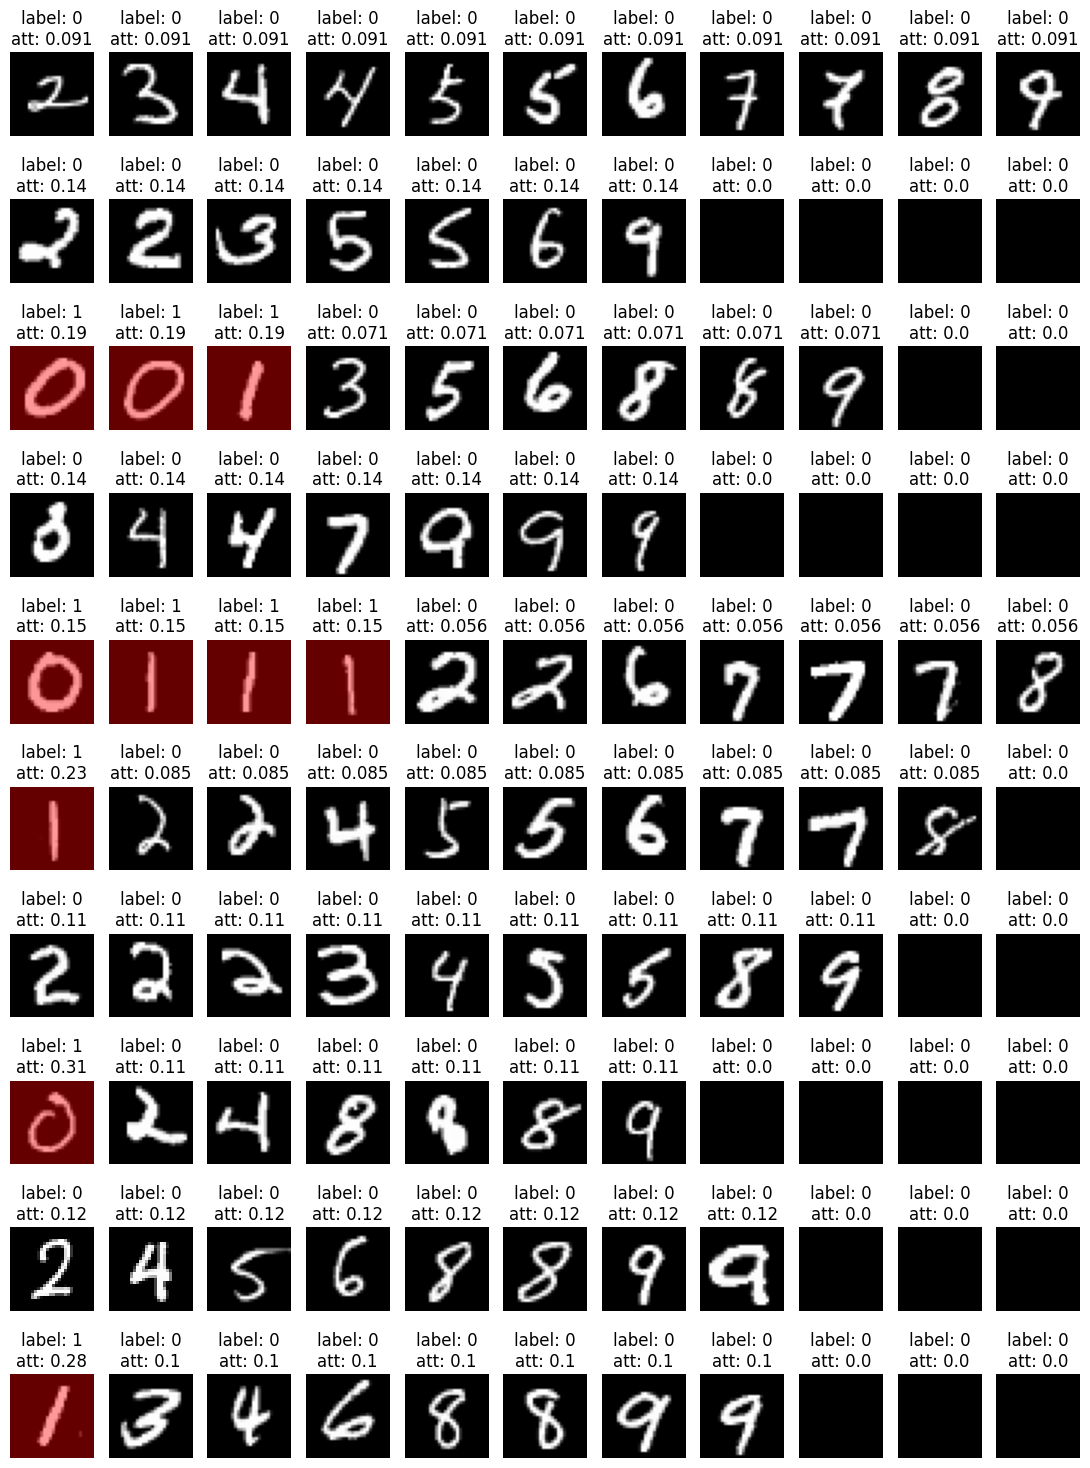

In [9]:
import numpy as np


def plot_batch_att(batch, att, max_bags=5):
    batch_size = min(len(batch["X"]), max_bags)
    bag_size = len(batch["X"][0])
    fig, axes = plt.subplots(batch_size, bag_size, figsize=(bag_size, 1.5 * batch_size))
    for i in range(batch_size):
        for j in range(bag_size):
            ax = axes[i, j]
            ax.imshow(batch["X"][i][j].view(28, 28), cmap="gray")
            # if the bag is positive, overlay red mask on the instance predicted as positive
            if batch["Y"][i] == 1:
                att_bag = normalize(
                    att[i].unsqueeze(0), batch["mask"][i].unsqueeze(0)
                ).squeeze(0)
                pred = (att_bag > 0.5).float()
                overlay_red = np.full(
                    (28, 28, 4), [1.0, 0.0, 0.0, 0.4 * pred[j].item()]
                )
                ax.imshow(overlay_red)
            title_str = (
                f"label: {batch['y_inst'][i][j].item()}\natt: {att[i][j].item():.2}"
            )
            ax.set_title(title_str)
            ax.axis("off")
    plt.tight_layout()
    plt.show()


batch = next(iter(test_dataloader))
batch = batch.to(device)
_, att = model(batch["X"], batch["mask"], return_att=True)
batch = batch.detach().cpu()
att = att.detach().cpu()
plot_batch_att(batch, att, max_bags=10)

As we can see, the model assigns more importance to the positive instances. This is a good sign! This means that the model itself learned to predict the positive instances correctly, even though it was not trained with instance-level labels. This is the power of Multiple Instance Learning!